# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [3]:
# Taking all imports for processing
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [5]:
# loading train-data in dataframes
train_identity_df = pd.read_csv("../data/train_identity.csv")
train_transaction_df = pd.read_csv("../data/train_transaction.csv")
global_df = pd.merge(left=train_transaction_df, right=train_identity_df, left_on=["TransactionID"],
                                       right_on="TransactionID", how="left")
# Since Part 1 to 5 would only involve following fields
# TransactionID,DeviceType,DeviceInfo,TransactionDT,TransactionAmt,ProductCD,card4,card6,P_emaildomain,R_emaildomain,addr1,addr2,dist1,dist2
# Loading above necessary fields into base dataframe
# And performing EDA on these data
basic_fields_df = global_df[["TransactionID", "TransactionDT", "TransactionAmt",
                                              "ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain", 
                                              "addr1", "addr2", "dist1", "dist2", "isFraud", "DeviceType", "DeviceInfo"]]

## Part 6 - Prediction Model

## Checking Duplicates for the significant fields across whole data-set
Testing whether there are any duplicates in the base data (TransactionID, DeviceType, DeviceInfo, TransactionDT, TransactionAmt, ProductCD, addr1, addr2, dist1, dist2, card4, card6, P_emaildomain, R_emaildomain) of transactions and devices.

---

Found that there are no duplicates since shape on `base_df[base_duplicates]` responds with 0 count against number of rows


In [6]:
base_duplicates = basic_fields_df.duplicated()
print("Number of duplicates in base fields: " + str(basic_fields_df[base_duplicates].shape[0]))

Number of duplicates in base fields: 0


In [7]:
basic_fields_df.isnull().sum().sort_values(ascending=False)

dist2             552913
DeviceInfo        471874
R_emaildomain     453249
DeviceType        449730
dist1             352271
P_emaildomain      94456
addr2              65706
addr1              65706
card4               1577
card6               1571
isFraud                0
ProductCD              0
TransactionAmt         0
TransactionDT          0
TransactionID          0
dtype: int64

In [8]:
basic_fields_df.dtypes

TransactionID       int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card4              object
card6              object
P_emaildomain      object
R_emaildomain      object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
isFraud             int64
DeviceType         object
DeviceInfo         object
dtype: object

In [19]:
modified_df = basic_fields_df.copy(deep=True)

## Cleaning and Pre-Processing ##

### [A] Dealing with missing values in card data in card6 field ###
#### Citation (https://towardsdatascience.com/the-ultimate-guide-to-data-cleaning-3969843991d4) ####
The strategy to handle missing values in card6 is as follows:
1.  During our previous EDA we observed that 48% of fraud transactions were done with credit card and 51% done with debit card.
    Also, for non-fraud transactions credit card was used 24% and 75% of times respectively
2.  Now, we will fill the missing values for card6 fields with either 'credit' or 'debit' value based on following criteria:

    a.  If it's a fraud transaction assign value 'credit' or 'debit' with ratio of randomness of 48 to 51
    
    b.  If it's a non-fraud transaction assign 'credit' or 'debit' with ratio of randomness of 24 to 75

In [20]:
non_fraud_indices = modified_df.index[((modified_df.isFraud == 0 ) & modified_df.card6.isnull())]
fraud_indices = modified_df.index[((modified_df.isFraud == 1) & (modified_df.card6.isnull()))]
print( "Index count: Fraud -> "+ str(fraud_indices.shape) + ", Non-Fraud ->" +  str(non_fraud_indices.shape))

fraud_card6_replacements = random.choices(['credit', 'debit'], [48, 51], k=fraud_indices.shape[0])
non_fraud_card6_replacements = random.choices(['credit', 'debit'], [24, 75], k=non_fraud_indices.shape[0])

i = 0
for index in fraud_indices:
    modified_df.iloc[index, modified_df.columns.get_loc('card6')] = fraud_card6_replacements[i]
    if i % 100 == 0:
        print("Fraud card6 filling, done with " + str(i) + " , remaining: " + str(len(fraud_indices) - i))
    i += 1
    
i = 0
for index in non_fraud_indices:
    modified_df.iloc[index, modified_df.columns.get_loc('card6')] = non_fraud_card6_replacements[i]
    if i % 100 == 0:
        print("Non fraud card6 filling, done with " + str(i) + " , of: " + str(len(non_fraud_indices) - i))
    i += 1
# modified_df.card6.isnull().sum()

Index count: Fraud -> (39,), Non-Fraud ->(1532,)
Fraud card6 filling, done with 0 , remaining: 39
Non fraud card6 filling, done with 0 , of: 1532
Non fraud card6 filling, done with 100 , of: 1432
Non fraud card6 filling, done with 200 , of: 1332
Non fraud card6 filling, done with 300 , of: 1232
Non fraud card6 filling, done with 400 , of: 1132
Non fraud card6 filling, done with 500 , of: 1032
Non fraud card6 filling, done with 600 , of: 932
Non fraud card6 filling, done with 700 , of: 832
Non fraud card6 filling, done with 800 , of: 732
Non fraud card6 filling, done with 900 , of: 632
Non fraud card6 filling, done with 1000 , of: 532
Non fraud card6 filling, done with 1100 , of: 432
Non fraud card6 filling, done with 1200 , of: 332
Non fraud card6 filling, done with 1300 , of: 232
Non fraud card6 filling, done with 1400 , of: 132
Non fraud card6 filling, done with 1500 , of: 32


### Cleaning card-issuer data in card4 field ###

In [21]:
non_fraud_indices = modified_df.index[((modified_df.isFraud == 0 ) & modified_df.card4.isnull())]
fraud_indices = modified_df.index[((modified_df.isFraud == 1) & (modified_df.card4.isnull()))]
print( "Index count: Fraud -> "+ str(fraud_indices.shape) + ", Non-Fraud ->" +  str(non_fraud_indices.shape))

fraud_card4_replacements = random.choices(['visa', 'mastercard', 'american express', 'discover'], [64, 31, 1, 2], k=fraud_indices.shape[0])
non_fraud_card4_replacements = random.choices(['visa', 'mastercard', 'american express', 'discover'], [65, 32, 1, 1], k=non_fraud_indices.shape[0])

i = 0
for index in fraud_indices:
    modified_df.iloc[index, modified_df.columns.get_loc('card4')] = fraud_card4_replacements[i]
    if i % 100 == 0:
        print("Fraud, Filling card4 field, done with " + str(i) + " , of: " + str(len(fraud_indices)))
    i += 1
    
i = 0
for index in non_fraud_indices:
    modified_df.iloc[index, modified_df.columns.get_loc('card4')] = non_fraud_card4_replacements[i]
    if i % 100 == 0:
        print("Fraud, Filling card4 field, done with " + str(i) + " , of: " + str(len(non_fraud_indices)))
    i += 1
# modified_df.card6.isnull().sum()

Index count: Fraud -> (41,), Non-Fraud ->(1536,)
Fraud, Filling card4 field, done with 0 , of: 41
Fraud, Filling card4 field, done with 0 , of: 1536
Fraud, Filling card4 field, done with 100 , of: 1536
Fraud, Filling card4 field, done with 200 , of: 1536
Fraud, Filling card4 field, done with 300 , of: 1536
Fraud, Filling card4 field, done with 400 , of: 1536
Fraud, Filling card4 field, done with 500 , of: 1536
Fraud, Filling card4 field, done with 600 , of: 1536
Fraud, Filling card4 field, done with 700 , of: 1536
Fraud, Filling card4 field, done with 800 , of: 1536
Fraud, Filling card4 field, done with 900 , of: 1536
Fraud, Filling card4 field, done with 1000 , of: 1536
Fraud, Filling card4 field, done with 1100 , of: 1536
Fraud, Filling card4 field, done with 1200 , of: 1536
Fraud, Filling card4 field, done with 1300 , of: 1536
Fraud, Filling card4 field, done with 1400 , of: 1536
Fraud, Filling card4 field, done with 1500 , of: 1536


### [B] Mapping multiple similar email domains to a single parent domain ###

In [22]:
email_domain_map = {
	'gmail.com': ['gmail.com', 'gmail'], 
  	'yahoo.com': ['yahoo.com', 'yahoo.com.mx', 'ymail.com', 'yahoo.de', 'yahoo.fr', 'yahoo.es', 'yahoo.co.uk', 'yahoo.co.jp'] , 
  	'hotmail.com': ['hotmail.com', 'outlook.com', 'live.com.mx', 'hotmail.es', 'msn.com', 'live.com', 'outlook.es', 'hotmail.de', 'hotmail.fr', 'hotmail.co.uk'],
  	'netzero.net': ['netzero.com', 'netzero.net'] ,
  	'icloud.com': ['mac.com', 'icloud.com']
}

reverse_email_domain_map = {}
for root_domain in email_domain_map:
    for domain in email_domain_map[root_domain]:
        reverse_email_domain_map[domain] = root_domain
# reverse_email_domain_map

modified_df['P_emaildomain'] = modified_df['P_emaildomain'].apply(lambda x: reverse_email_domain_map[x] if x in reverse_email_domain_map else x)
modified_df['R_emaildomain'] = modified_df['R_emaildomain'].apply(lambda x: reverse_email_domain_map[x] if x in reverse_email_domain_map else x)

### Citation: ###
1. https://www.pluralsight.com/guides/handling-categorical-data-in-machine-learning-models
2. https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621
3. http://www.insightsbot.com/blog/McTKK/python-one-hot-encoding-with-scikit-learn
4. http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
5. https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
6. https://discuss.analyticsvidhya.com/t/how-to-handle-missing-values-of-categorical-variables/310

In [23]:
modified_df['addr1'] = modified_df['addr1'].fillna('special_region')
modified_df['addr2'] = modified_df['addr2'].fillna('special_country')

In [24]:
def one_hot_encode(df, col_name, col_prefix=''):
    if len(col_prefix) > 0:
        one_hot_encoding = pd.get_dummies(df[col_name], prefix=col_prefix)
    else:
        one_hot_encoding = pd.get_dummies(df[col_name])
    new_df = df.copy(deep=True)
    new_df = new_df.drop(col_name, axis=1)
    new_df = new_df.join(one_hot_encoding)
    
    return new_df

In [25]:
pre_processing_df = modified_df.drop(['TransactionID', 'dist1', 'dist2', 'DeviceInfo'], axis = 1)
# modeling_df.head()

In [26]:
pre_processing_df = one_hot_encode(pre_processing_df, 'card4')
pre_processing_df = one_hot_encode(pre_processing_df, 'card6')
pre_processing_df = one_hot_encode(pre_processing_df, 'P_emaildomain', col_prefix='purchaser_')
pre_processing_df = one_hot_encode(pre_processing_df, 'R_emaildomain', col_prefix='recipient_')
pre_processing_df = one_hot_encode(pre_processing_df, 'ProductCD')
pre_processing_df = one_hot_encode(pre_processing_df, 'DeviceType')
pre_processing_df = one_hot_encode(pre_processing_df, 'addr1', col_prefix='addr1_')
pre_processing_df = one_hot_encode(pre_processing_df, 'addr2', col_prefix='addr2_')

In [27]:
input_dataset_x = pre_processing_df.drop(['isFraud'], axis=1)
input_dataset_y = pre_processing_df['isFraud']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(input_dataset_x, input_dataset_y, random_state=31)

In [29]:
classifier = LogisticRegression(solver='lbfgs').fit(X_train, y_train)

In [31]:
y_predictions = classifier.predict(X_test)

### Citation: Confusion Matrix
1.  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [35]:
def plot_confusion_matrix(y_test, y_predictions, labels=[1,0]):
    mat = confusion_matrix(y_test, y_predictions, labels)
    print("Confusion Marix: ")
    print(str(mat))
    sns.heatmap(mat)
    plt.tight_layout()

Confusion Marix: 
[[     0   5095]
 [     0 142540]]


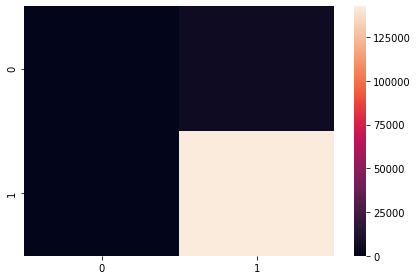

In [36]:
plot_confusion_matrix(y_test, y_predictions)

In [37]:
classifier.score(X_test, y_test)

0.9654892132624378

In [53]:
classifier.predict_proba(X_test)

array([[9.99194533e-01, 8.05467270e-04],
       [9.98965205e-01, 1.03479476e-03],
       [9.93256770e-01, 6.74323022e-03],
       ...,
       [9.96259534e-01, 3.74046646e-03],
       [9.82805029e-01, 1.71949714e-02],
       [9.98095688e-01, 1.90431223e-03]])

### Citations ###
1. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
2. https://www.youtube.com/watch?v=4jRBRDbJemM

In [165]:
roc_auc_score(y_test, predictions)

0.5

In [164]:
pass

In [127]:
classifier.score(X_test, y_test)

0.9651166728756732

## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: FILL HERE

Highest Rank: FILL HERE

Score: FILL HERE

Number of entries: FILL HERE

INCLUDE IMAGE OF YOUR KAGGLE RANKING